# ECE176: Pneumonia Detection, CNN

## Introduction

**In this report, we aim to address the following questions:**

1. How accurately can we distinguish healthy and pneumonia patients with our CNN? 

2. Can we distinguish between viral and bacterial pneumonia? 
       
3. Can we use pre-trained CNNs or UNET models to create a more accurate model? 

## Dataset

[Collection of Chest X Ray of Healthy vs Pneumonia affected patients](https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset)

## Import Packages and Prepare GPU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import os
import pandas as pd
import shutil

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Load Dataset With Augmentations

We first need to split the images based on labeled classes. 
**Note: This only needs to be run one time**

In [3]:
# first read in the metadata file
data = pd.read_csv("Chest_xray_Corona_Metadata.csv")
data.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print(set(data['Label']))

{'Normal', 'Pnemonia'}


In [5]:
# subdirectories for each class
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Normal")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Normal")

In [6]:
path_train = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
path_test = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

train_num = len(os.listdir(path_train))
print("Train data: " + str(train_num))
test_num = len(os.listdir(path_test))
print("Test data: " + str(test_num))


Train data: 5311
Test data: 626


In [7]:
# ONLY NEED TO RUN ONCE

normal_train = 0
pnemonia_train = 0
normal_test = 0
pnemonia_test = 0

# "X_ray_image_name" = name of file
# "Label" = pneumonia or normal
# "Dataset_type" = train or test

for i in range(data.shape[0]):
    if data["Dataset_type"][i] == "TRAIN":
        if data["Label"][i] == "Normal":
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Normal/" + data["X_ray_image_name"][i])
            normal_train = normal_train + 1
        else:
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_train = pnemonia_train + 1
    elif data["Dataset_type"][i] == "TEST":
        if data["Label"][i] == "Normal":
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Normal/" + data["X_ray_image_name"][i])
            normal_test = normal_test + 1
        else:
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_test = pnemonia_test + 1

print(
    "X-ray of Normal patients (TRAIN DATASET): " + str(normal_train) + "\n",
    "X-ray of Infected patients (TRAIN DATASET): " + str(pnemonia_train) + "\n",
    "X-ray of Normal patients (TEST DATASET): " + str(normal_test) + "\n",
    "X-ray of Infected patients (TEST DATASET): " + str(pnemonia_test) + "\n"
)

X-ray of Normal patients (TRAIN DATASET): 1342
 X-ray of Infected patients (TRAIN DATASET): 3944
 X-ray of Normal patients (TEST DATASET): 234
 X-ray of Infected patients (TEST DATASET): 390



In [8]:
# redefine number of train test 
train_num = normal_train + pnemonia_train
print("Train data: " + str(train_num))
test_num = normal_test + pnemonia_test
print("Test data: " + str(test_num))

Train data: 5286
Test data: 624


In [9]:
train_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
test_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"
batch_size = 64

# data augmentation 
transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(), # horizontal flips
    T.CenterCrop(256), # crops
    T.ToTensor(),
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # hard coded mean and std rgb values from assignment 5
    ])

train_data = dset.ImageFolder(root=train_data_path, transform=transform)
train_data_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(train_num)))
test_data = dset.ImageFolder(root=test_data_path, transform=transform)
test_data_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(test_num))) 


# Visualize Data

In the provided dataset, we categorize the images into two distinct classes: 'Normal' and 'Pneumonia'. To visually differentiate between these two types, we apply color coding: 'Normal' instances are labeled in red, while 'Pneumonia' cases are marked in green. This color scheme aids in the immediate visual identification of each category, enhancing our analysis and interpretation of the data.

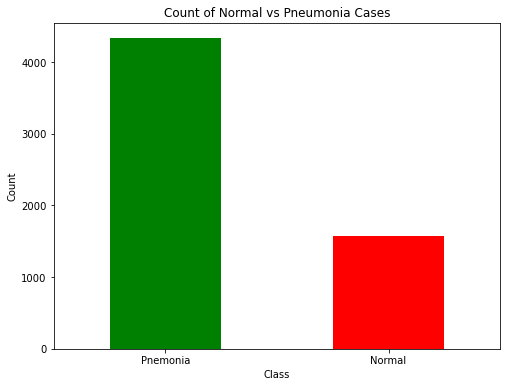

Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = data['Label'].value_counts()

# Specify colors for each class
colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

# Plotting
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Count of Normal vs Pneumonia Cases')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the class names horizontal for readability
plt.show()
print(class_counts)

In [11]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 5)) 
    plt.imshow(inp, cmap='gist_heat')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  





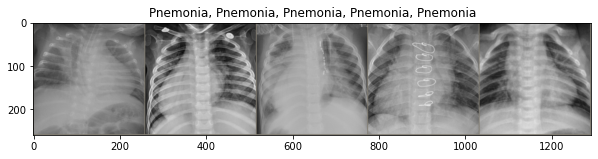

In [12]:
inputs, classes = next(iter(train_data_loader))


indices = torch.randperm(len(inputs))[:5]
selected_inputs = inputs[indices]
selected_classes = classes[indices]

# Make a grid from the selected batch
out = torchvision.utils.make_grid(selected_inputs)

# Create titles for the selected images
selected_titles = ', '.join([train_data.classes[x] for x in selected_classes])

# Call imshow with the selected images and titles
imshow(out, title=selected_titles)

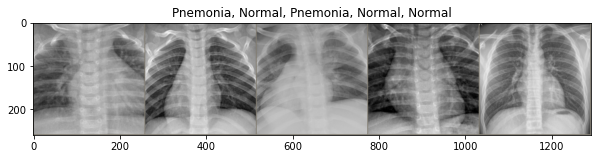

In [13]:
inputs, classes = next(iter(test_data_loader))

indices = torch.randperm(len(inputs))[:5]
selected_inputs = inputs[indices]
selected_classes = classes[indices]

out = torchvision.utils.make_grid(selected_inputs)

selected_titles = ', '.join([test_data.classes[x] for x in selected_classes])

imshow(out, title=selected_titles,)


List random 5 picture about normal and pnemonia. And We can see that the normal is have shalldow around the lungs area and the pnemonia doesn't. 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as dset

# Define the CNN architecture
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=3):  # 3 classes: Normal, Viral Pneumonia, Bacterial Pneumonia
        super(PneumoniaCNN, self).__init__()
        # Define layers of a CNN, changing the input channels from 1 to 3 for RGB images
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 64 * 64, 512)  
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the layer
        x = x.view(-1, 64 * 64 * 64)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_classes = 3  # Normal, Viral Pneumonia, Bacterial Pneumonia
model = PneumoniaCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 25

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

print('Finished Training')


Finished Training


In [16]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')


Accuracy of the model on the test images: 75.48076923076923%


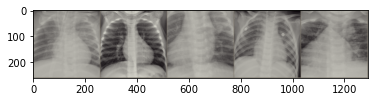

True labels:  Pnemonia Normal Pnemonia Pnemonia Pnemonia
Predicted:  Pnemonia Normal Pnemonia Pnemonia Pnemonia


In [25]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    plt.imshow(img)
    plt.show()

# Assuming test_data_loader has batch_size at least 5 or adjust as necessary
# Get a batch of test images and labels
dataiter = iter(test_data_loader)
images, labels = next(dataiter)

# Select random 5 indices
idx = np.random.choice(images.size(0), 5, replace=False)

# Select random images and labels
random_images = images[idx]
random_labels = labels[idx]

# Move tensors to the configured device
random_images, random_labels = random_images.to(device), random_labels.to(device)

# Get predictions
model.eval()  # Make sure model is in eval mode
with torch.no_grad():
    outputs = model(random_images)
    _, predicted = torch.max(outputs, 1)

# Show images
imshow(torchvision.utils.make_grid(random_images.cpu()))
# Print true and predicted labels
print('True labels: ', ' '.join(f'{test_data.classes[random_labels[j].item()]}' for j in range(len(random_labels))))
print('Predicted: ', ' '.join(f'{test_data.classes[predicted[j].item()]}' for j in range(len(predicted))))